NIVEL 1

Realiza la conexión en Python con MySQL Workbench para cargar toda la información que tienes en las tablas.

Realizarás una visualización para cada ejercicio. Comenta lo que llama la atención de graficar esta variable, justifica la elección del gráfico e interpreta los resultados en función de tus datos.

In [1]:
#Se importa todo lo necesario
import pymysql
import cryptography
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
 #Seteado el estilo de los gráficos
sns.set_style('darkgrid')

In [2]:
#Se establece la conexión con Workbench
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='4321',
                             database='business_db')

print("Conexion Establecida")

cursor = connection.cursor()

print("Cursor creado")

Conexion Establecida
Cursor creado


In [4]:
#Bloque para cerrar la conexión al terminar
connection.close()
print("Conexion Cerrada")

Conexion Cerrada


EXTRA: Se añade una columna a users con el user_cohort en función del gasto

In [16]:
cursor.execute('ALTER TABLE users ADD user_cohort VARCHAR(20)')

0

In [17]:
cursor.execute('UPDATE users u JOIN(SELECT transactions.user_id, sum(transactions.amount) as "cantidad" FROM transactions WHERE transactions.declined = 0 GROUP BY user_id) t ON u.id = t.user_id SET u.user_cohort = CASE WHEN t.cantidad < 100 THEN "Minnow" WHEN t.cantidad < 500 THEN "Dolphin" WHEN t.cantidad < 1000 THEN "Whale" ELSE "Kraken" END;')

216

EXTRA: Se añade una columna a transactions con la cantidad de productos adquirida en cada transacción

In [23]:
cursor.execute('ALTER TABLE transactions ADD cantidad_productos smallint')

0

In [24]:
cursor.execute('UPDATE transactions t JOIN(SELECT bought_products.transactions_id, count(bought_products.transactions_id) as "cuenta" FROM bought_products GROUP BY transactions_id) bp ON t.id = bp.transactions_id SET t.cantidad_productos = bp.cuenta')

587

In [18]:
connection.commit()

In [3]:
transactionsDf = pd.read_sql_query('select * from transactions', connection)
companiesDf = pd.read_sql_query('select * from companies', connection)
creditCardsDf = pd.read_sql_query('select * from credit_cards', connection)
productsDf = pd.read_sql_query('select * from products', connection)
usersDf = pd.read_sql_query('select * from users', connection)
boughtProductsDf = pd.read_sql_query('select * from bought_products', connection)

C:\Users\Maeloc\AppData\Local\Temp\ipykernel_20548\3053626486.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transactionsDf = pd.read_sql_query('select * from transactions', connection)
C:\Users\Maeloc\AppData\Local\Temp\ipykernel_20548\3053626486.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companiesDf = pd.read_sql_query('select * from companies', connection)
C:\Users\Maeloc\AppData\Local\Temp\ipykernel_20548\3053626486.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  creditCardsDf = pd.read_sql_query('sele

- Ejercicio 1

Una variable numérica.

Variable numérica:
- Amount en transacciones válidas

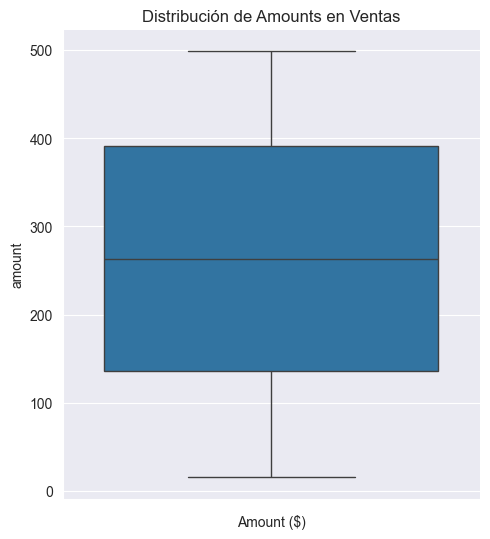

In [7]:
validAmountsDf = transactionsDf[transactionsDf['declined'] == 0]

sns.catplot(validAmountsDf['amount'], 
            kind = 'box')
plt.xlabel('Amount ($)')
plt.title('Distribución de Amounts en Ventas')

plt.show() #Para eliminar el texto que se genera encima del grafico

Este gráfico ha sido elegido para mostrar la distribución de las "Amount" válidas (Aquellas que pertenecen a transacciones no declinadas). Como podemos apreciar, la distribución es bastante uniforme, a pesar de que se puedde apreciar una ligerísima varianza hacia amounts superiores a la mediana. No se aprecian "Outliers".

- Ejercicio 2

Dos variables numéricas.

Variables numéricas:
- Peso del producto
- Precio del producto

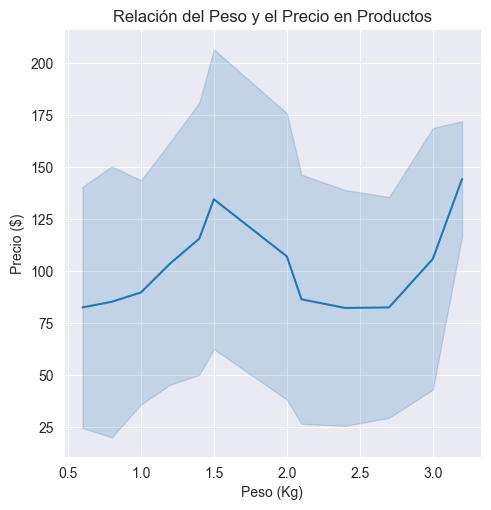

In [8]:
sns.relplot(productsDf, 
            x= 'weight', y= 'price_dollars', 
            kind='line', 
            errorbar= 'sd')
plt.xlabel('Peso (Kg)')
plt.ylabel('Precio ($)')
plt.title('Relación del Peso y el Precio en Productos')

plt.show()

El objetivo de graficar estas dos variables es ver si existe algún tipo de relación entre el peso del producto y su precio. Para ello se ha elegido un relplot tipo lineal. Si bien cabría esperar que a mayor peso mayor precio esto no es necesariamente así, si no que hay dos 'pesos' que concentran la mayor cantidad de precio (1.5 y 3kg).
 
Hay que resaltar también lo amplia que es la desviación estándar en toda la linea, lo que también indica lo 'inestables' que son los dos datos por si mismos, a pesar de mantener la forma. A mayor peso sí que parecen estabilizarse, lo que podría indicar una relación más fiable (habría que graficar la distribución de pesos para acabr de tener la info necesaria, ya que es posible que solo se deba a que hay una menor cantidad de productos con ese peso).

- Ejercicio 3

Una variable categórica.

Variable categórica:
- Product Name

In [9]:
transactionsBProductsDf = pd.merge(transactionsDf, boughtProductsDf, left_on='id', right_on='transactions_id')
transactionsProductsDf = pd.merge(transactionsBProductsDf, productsDf, left_on= 'product_id', right_on='id')
cantidadProductosVendida = transactionsProductsDf.groupby('product_id').agg({'product_name':'first', 'id_x':'count'}).reset_index().rename(columns={'product_name':'product name', 'id_x':'cantidad'})

cpvPie = px.pie(cantidadProductosVendida, 
                values='cantidad', 
                names='product name', 
                title='Productos Vendidos',
                color_discrete_sequence=px.colors.sequential.ice)

cpvPie.update_traces(insidetextorientation='radial')

cpvPie.update_layout(
    margin = dict(t=50, l=100, r=10, b=50))

cpvPie.show()

Con estre grafico en forma de tarta, se muestra el volumen de compras por producto (en transacciones válidas). Como se puede observar, hay una clara predilección por dos productos concretos: "Skywalker ewok" y "Direwolf Stannis". El resto de productos tienen un porcentaje de compra relativamente parecido. Con la segmentación de usuarios pertinente, este gráfico podría cambiar y orientar la estrategia hacia los grupos con más volumen de gasto.

- Ejercicio 4
Una variable categórica y una numérica.

Variable categórica:
- User Cohort

Variable numérica:
- Amount generado en transacciones válidas

In [10]:
transactionsUsersDf = pd.merge(transactionsDf, usersDf, left_on= 'user_id', right_on= 'id')
transactionsUsersDfFiltered = transactionsUsersDf[transactionsUsersDf['declined'] == 0]


cpvPie = px.pie(transactionsUsersDfFiltered, 
                values='amount', 
                names='user_cohort', 
                title='Productos Vendidos',
                color_discrete_sequence=px.colors.sequential.Magma_r)

cpvPie.update_layout(
    margin = dict(t=50, l=100, r=10, b=50))

cpvPie.show()

El objetivo de este gráfico de tarta es analizar el revenue procedente de cada tipo de user cohort. Como se puede apreciar en el gráfico, los usuarios Kraken son la principal fuente de ingresos. Sorprende que los Dolphin sean la segunda y no los whale, como cabría esperar por la clasificación del gasto

- Ejercicio 5

Dos variables categóricas.

Variables categóricas:

- País de origen de la transacción
- País destinatario de la transacción

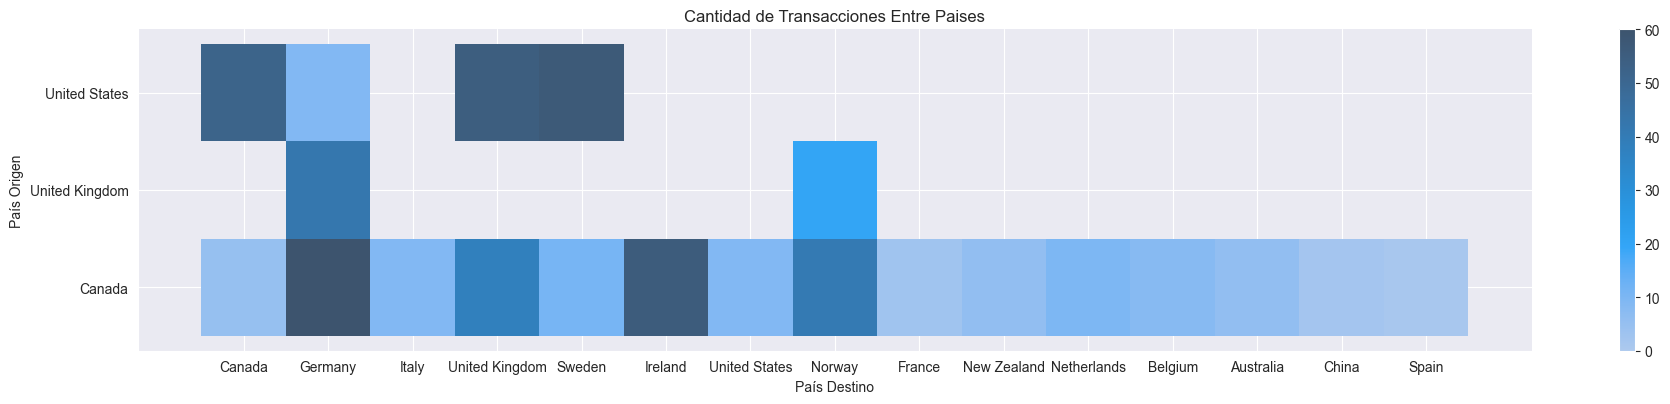

In [11]:
transactionsUsersCompaniesDf = pd.merge(transactionsUsersDf, companiesDf, left_on='business_id', right_on='company_id')
transactionsUsersCompaniesDfFiltered = transactionsUsersCompaniesDf[transactionsUsersCompaniesDf['declined'] == 0].rename(columns={'country_x':'País Origen', 'country_y':'País Destino'})



sns.displot(transactionsUsersCompaniesDfFiltered, 
            x='País Destino', y='País Origen', 
            height=4, aspect=4.75, 
            cbar= True)
plt.title("Cantidad de Transacciones Entre Paises")

plt.show()

Para este gráfico he escogido mostrar la distribución de las ventas válidas por pais. En el eje X, podemos ver a que empresa se le hacen los pedidos, en el eje Y desde que pais. La intensidad del color representa el volumen de dichas ventas. 

Como se puede observar, Canadá ha hecho pedidos a todas las empresas, pero se nota cierta inclinación a realizarlas a Alemania e irlanda. También a UK y Noruega, pero en menor medida.

USA, por otra banda, parece tener muy claro a que paises pedir, ya que siempre parece pedir a los mismos países, siendo Alemania el que menos pedidos ha recibido.

Finalmente, UK, no tiene un gran voulmen de pedidos, como se ha podido ver en anteriores gráficos, por lo que el volumen de estos no es tan intenso (en color) como los otros dos paises. No obstante se puede apreciar cierta predilección por Alemania, aunque también han pedido a Noruega

- Ejercicio 6

Tres variables.

Variables categóricas:

- País destinatario de la transacción
- Empresa destinataria de la transacción

Variables numéricas:

- Amount

In [12]:
transactionsCompaniesDf = pd.merge(transactionsDf, companiesDf, left_on='business_id', right_on='company_id')
transactionsCompaniesDfFiltered = transactionsCompaniesDf[transactionsCompaniesDf['declined'] == 0]
amountPaisEmpresa = transactionsCompaniesDfFiltered.groupby(['company_id']).agg({'amount': 'sum', 'country': 'first', 'company_name': 'first'}).reset_index().rename(columns={'country':'País Destino', 'company_name':'Nombre de la Empresa'})

fig = px.sunburst(amountPaisEmpresa,
                  path=['País Destino', 'Nombre de la Empresa'], 
                  values='amount',
                  width=1000,
                  height=1000,
                  title= 'Amount por País y Compañía',)

fig.update_traces(insidetextorientation='radial')

fig.show()

Este gráfico sirve para expandir la información del gráfico del ejercicio 4. El objetivo de este gráfico "Sunburst" es entrar más a fondo en la distribución de los ingresos por pais y sus distintas empresas empresas. Se han añadido los paises como "parent" y las empresas como "Labels". 

Como se puede observar, el grueso de los ingresos viene de 6 países y, en cada pais, de una o dos compañías. Esto demuestra una ineficiencia total en cuanto a la distribución de recursos.

- Ejercicio 7

Graficar un Pairplot.

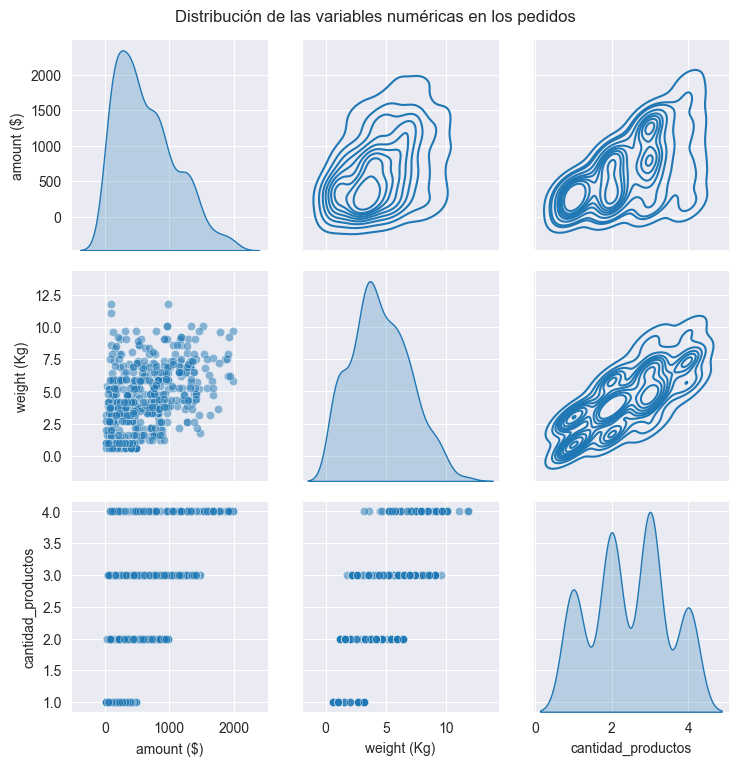

In [13]:
transactionsProductsDfFiltered = transactionsProductsDf[transactionsProductsDf['declined'] == 0]
pairplotDf = transactionsProductsDfFiltered.groupby('id_x').agg({'amount':'sum', 'weight':'sum', 'cantidad_productos':'first'}).reset_index().rename(columns={'amount':'amount ($)', 'weight':'weight (Kg)'})

grid = sns.PairGrid(pairplotDf, 
                    diag_sharey=False)
grid.map_diag(sns.kdeplot, 
              fill=True)
grid.map_lower(sns.scatterplot, 
               alpha=0.5)
grid.map_upper(sns.kdeplot)
plt.title('Distribución de las variables numéricas en los pedidos', 
          y=3.25, x=-0.8)
plt.show()

Para graficar este pairplot he seleccionado las pocas variables que considero que tienen un mínimo de relación . El objetivo es analizar a grandes rasgos la distribución del contenido de los pedidos (en transacciones válidas) y dar una imagen global de los elementos que los componen. Estas son:

- Amount de cada pedido
- Peso total de todos los productos del pedido (O cuanto pesa el paquete)
- Cantidad de productos adquirida por pedido

La diagonal representa la distribución de los elementos, la parte inferior el detalle en cada pedido y, el kde de la parte superior, busca proporcionar una manera más generalista de mostrar la distribución de los resultados. En cuanto a los resultados mostrados:

- En la diagonal
    - Amount: Se ve claramente una inclinación hacia transacciones de "menor valor" por regla general. A mayor amount, menos cantidad de transacciones de ese estilo.
    - Peso total: Claramente hay una predominancia de pedidos con pesos entre los 3 y los 4 Kg, por lo que se puede asumir que la mediana de al distribución rondaría esas cifras.
    - Cantidad de productos adquiridos: La gran mayoría de los pedidos cuenta con de 2 a 3 productos.

- Fuera de la diagonal
    - Peso total Vs. Amount: Como hay una relación directa entre el peso del pedido y la cantidad de productos, esta parece estar afectando a estas dos variables de manera indirecta. Cuánto más ligero es el producto, más tiende a tener un valor (amount) menor.
    - Cantidad de productos adquiridos Vs. Amount: En este gráfico parece haber una relación evidente. Como es lógico, la cantidad gastada tiende a escalar con la cantidad de productos adquiridos.No obstante, llama la atención como se dispersa la concentración en la cantidad de compras con niveles de gasto similares, a medida que crece la cantidad de productos adquirida
    - Cantidad de productos adquiridos Vs. Peso total: Es el gráfico con mayor correlación. Tiene sentido que cuantos más productos haya en un pedido, mas pese el paquete.

Este tipo de datos podrían ser analizados por departamentos de producto para establecer unos valores minimos para decidir el precio de los envios, por ejemplo.


NIVEL 2

Ejercicio 1

Correlación de todas las variables numéricas.

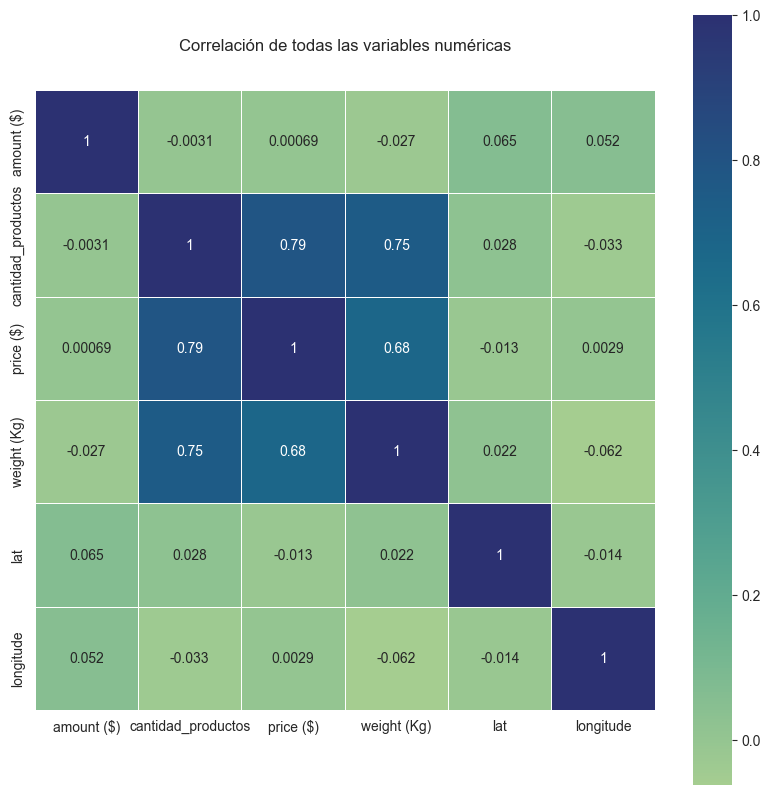

In [14]:
todoNumerico = transactionsProductsDfFiltered.groupby('id_x').agg({'amount':'first', 'cantidad_productos':'first', 'price_dollars':'sum', 'weight':'sum','lat':'first', 'longitude':'first'}).reset_index().rename(columns={'amount':'amount ($)', 'price_dollars':'price ($)', 'weight':'weight (Kg)'})
todoNumerico = todoNumerico.drop(columns='id_x')
todoNumericoCorr = todoNumerico.corr()

minValues = todoNumericoCorr.min() # Min de cada columna en una nueva columna
minValues = minValues.min() # Min de todos los min

fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(todoNumericoCorr, 
            vmin=minValues, 
            annot=True, 
            linewidths= 0.5, 
            cmap='crest', 
            square=True)
plt.title('Correlación de todas las variables numéricas', y=1.05)

plt.show()

Para este gráfico se han elegido todas las variables numéricas disponibles en la base de datos y se han agrupado por transacción. Para las variables numéricas de la tabla transactions se ha quedado con el primer resultado y las de productos como sum:
- Amount
- Cantidad Productos
- Price
- Weight
- Lat
- Longitude

Se ha seleccionado el tipo de gráfico como heatmap, ya que representa perfectamente, a simple vista, la relación a través de un código de color descrito en la "color bar". Además, se han añadido anotaciones para facilitar su lectura.

En cuanto al contenido e interpretación, si bien correlación no implica causalidad, parece la mayoría de variables son bastante independientes unas de otras. como excepción tenemos:

- Cantidad de productos Vs. precio: hay una correlación grande con un valor positivo. Esto indica que, como es lógico, a mayor cantidad de productos, más alto es el precio total de los productos de la transacción.

- Cantidad de productos Vs. peso: Otra vez nos encontramos con una correlación grande con un valor positivo. Cuantos más productos haya en el pedido mayor será su peso.

- Precio Vs. Peso: Tiene una correlación grande pero un poco más ligera que en los otros casos. Cuanto más pese el "paquete" de la transacción, más probable es que el precio escale.

Ejercicio 2

Implementa un jointplot.

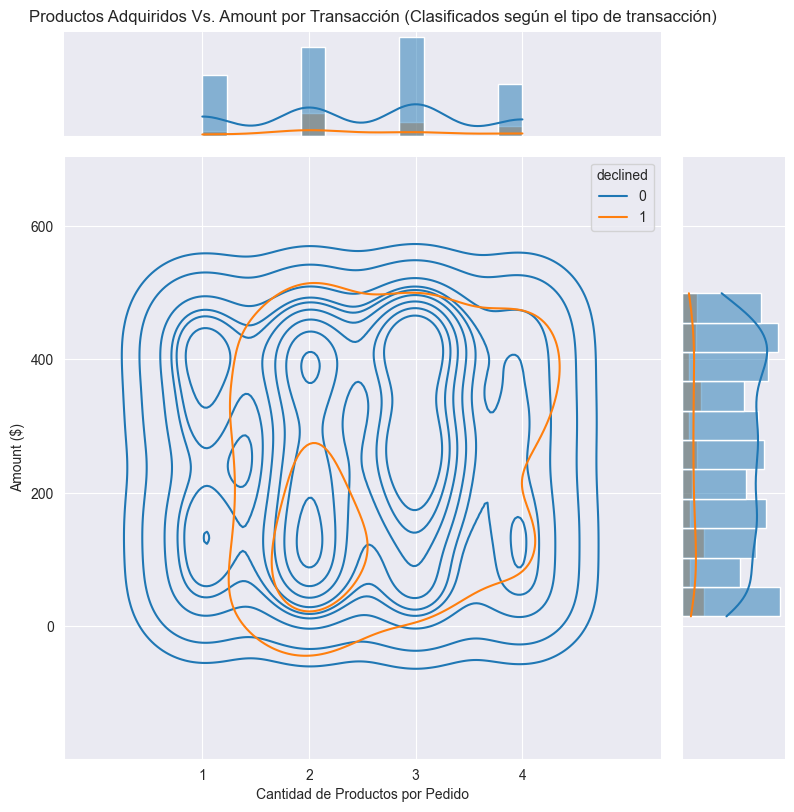

In [15]:
ticks = transactionsDf['cantidad_productos'].sort_values(ascending=True).unique() #Si no crea columnas x.5 para cada cantidad


relPlotNum = sns.JointGrid(transactionsDf, 
                           y='amount', x='cantidad_productos', 
                           hue='declined',
                           height= 8 )
relPlotNum.plot_joint(sns.kdeplot)
relPlotNum.plot_marginals(sns.histplot, 
                          kde=True)
relPlotNum.ax_joint.set_xticks(ticks)
relPlotNum.ax_joint.set_xlabel('Cantidad de Productos por Pedido')
relPlotNum.ax_joint.set_ylabel('Amount ($)')
plt.title('Productos Adquiridos Vs. Amount por Transacción (Clasificados según el tipo de transacción)', 
          y=1.21, 
          x=-3)

plt.show()

A través de este gráfico 'Jointplot' se intenta apreciar la distribución de la media de gasto en relación a la cantidad de productos adquiridos por compra (en transacciones válidas). Como es lógico, la cantidad gastada tiende a escalar con la cantidad de productos adquiridos. No obstante, llama la atención como, en compras de 4 productos, esta norma se rompe, haciendo que los pedidos con 3 productos sean los más propensos a tener un mayor volumen de gasto. Considero que el grafico en kde facilita la visualización de la concentración de estas variables.

Gracias a la distribucción de los 'marginals' podemos, además, saber que la mayor cantidad de transacciones contienen de 2 a 3 productos (lo cual podría explicar la excepción comentada previamente en pedidos con 4 productos), y sin embargo, la mayor cantidad de amount generado por transacción oscila por debajo de los 500. Se podría asumir que el grueso de pedidos constan de varios productos relativamente baratos.

Además, se ha incluido el tipo de transacción en el análisis lo que permite ver que las cantidades que no se han llegado a obtener, suelen ser más bajas de lo normal, por lo que no se debería considerar una pérdida sustancial.

NIVEL 3

Ejercicio 1

Implementa un violinplot combinado con otro tipo de gráfico.

Variables numéricas:
- Amount

Variables categóricas:
- Pais de origen de la transacción
- Tipo de transacción (declined)

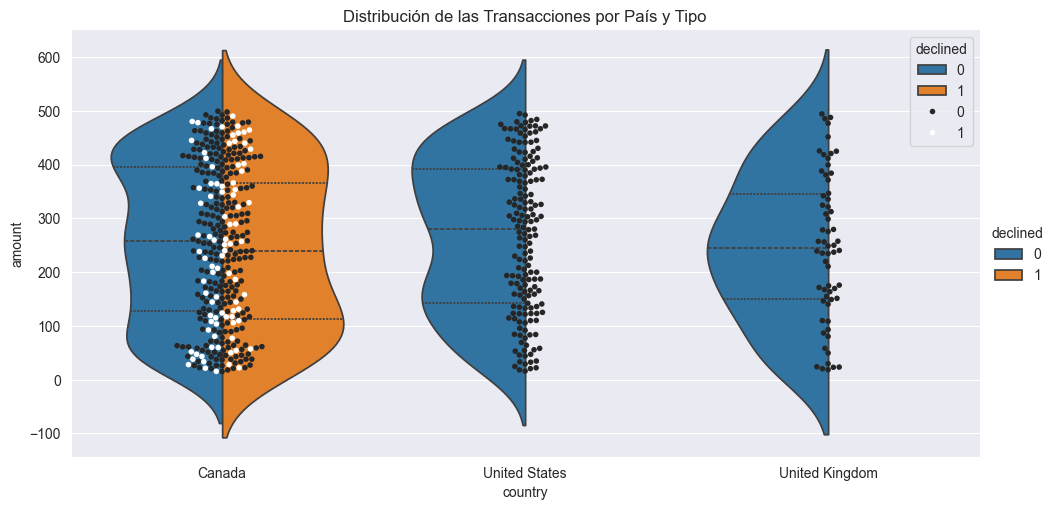

In [16]:
orderDf = transactionsUsersDf.groupby('country')['amount'].count().sort_values(ascending=False).index

base = sns.catplot(transactionsUsersDf, 
                   kind='violin', 
                   split=True, 
                   x='country', y='amount', 
                   hue='declined', 
                   inner='quart', 
                   order=orderDf, 
                   aspect=2)
sns.swarmplot(transactionsUsersDf, x='country', y='amount', hue= 'declined', ax=base.ax, palette='dark:white', size=4)
plt.title('Distribución de las Transacciones por País y Tipo')

plt.show()

En esta combinación de gráficos, el gráfico en violín describe la distribución del amount entre transacciones por país de origen mientras que el gráfico en 'swarm' describe con mayor precisión cada transacción realizada desde dichos paises. Además, gracias a la separacion de colores, se puede observar que Canadá es el único país con transacciones rechazadas (lo cual sugiere una investigación del motivo). En cuanto a las insights que podemos extraer:

- Canadá: Como se puede apreciar en el 'swarmplot', Canadá es el país con mayor volumen de transacciones. Además parece que la mayor concentración de transacciones radican en la parte superior del 'violinplot, por lo que podemos intuir una media de gasto relativamente alta, aunque más distribuida que en otros paises.  En lo referente a las transacciones rechazadas, la mayor concentración de estras mismas se aumulan en la base de 'violinplot', por lo que podemos asumir que las pérdidas no han sido muy graves.

- USA: USA es el segundo país con más transacciones. Su distribución parece inclinarse hacia la parte alta del 'violinplot' y no está tan regularmente distribuida como en Candá, por lo que se podría asumir que la media de gasto es la más alta de las 3.

- UK: En el 'violinplot' de UK se puede observar una clara inclinación hacia la mediana. No obstante, y gracias al 'swarmplot', podemos saber que UK no tiene una gran cantidad de transacciones, lo que hace que la muestra sea más 'maleable' que las demás.


Ejercicio 2

Genera un FacetGrid para visualizar múltiples aspectos de datos simultáneamente.

C:\Users\Maeloc\AppData\Local\Temp\ipykernel_20548\3990845184.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



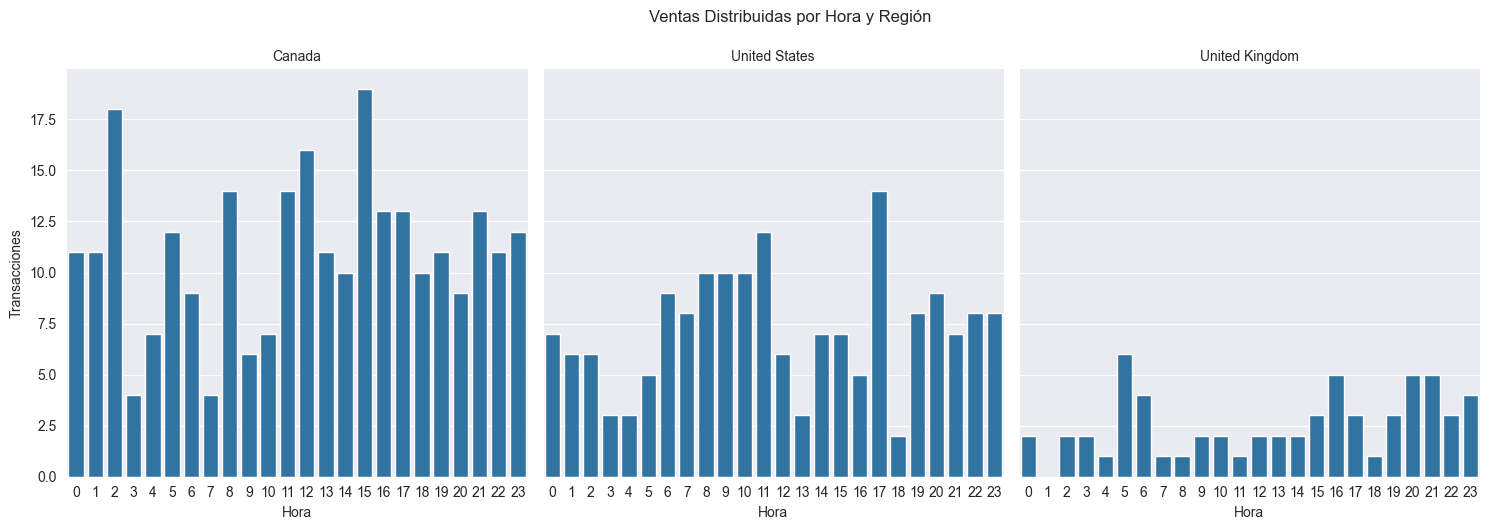

In [23]:
transactionsUsersDfFiltered['hora'] = transactionsUsersDfFiltered['timestamp'].dt.hour
facetGridDf = transactionsUsersDfFiltered[['hora','country']]

#Bloque para setear el orden
facetOrderDf = facetGridDf['hora'].sort_values(ascending=True)
facetOrderDf = facetOrderDf.unique()
facetOrderDf

g = sns.FacetGrid(facetGridDf, 
                  col='country', 
                  col_order=orderDf,
                  height=5, aspect=1)
g.map(sns.countplot, 'hora', order=facetOrderDf)
g.set_axis_labels('Hora', 'Transacciones')
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Ventas Distribuidas por Hora y Región', y=1.05, x=0.53)

plt.show()

Este facet grid muestra un countplot para cada país donde se analizan las transacciónes, dependiendo de la hora del pedido (en transacciones válidas). El objetivo es localizar las horas "calientes" de cada territorio y usarlas en distintas estrategias de marketing, como ofertas flash o notificaciones, enfocadas a usuarios en dichos países.

En cuanto a los datos obtenidos, no parece haber un patrón diferenciable, por lo que habría que sacar insights muy concretas por cada zona:
- Canadá: Sus horas fuertes son las 2:00, 15:00 y 12:00. Además, en general, parece haber un pico de actividad entre las 11:00 y las 18:00.
- USA: A pesar de que su pico está en las 17:00, parece haber una franja de actividad entre las 6:00 y las 11:00.
- UK: Este pais tiene poca data en general, por lo que estos datos hay que pillarlos con pizas. Su hora clave son las 5:00, pero parece haber una franja de ventas entre las 16:00 y las 23:00 (ignorando las 18:00).
